In [2]:
# Import Standard Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## EDA Plans:

1. Look at the distribution of each variable from train and test sets

2. Look at the correlation between variables

3. Try different transformations for the data 

4. Look at the distribution of fraud on a time-series

In [3]:
# Load Data
fraud_train = pd.read_csv('train.csv')
fraud_test = pd.read_csv('test.csv')
submission = pd.read_csv('sample_submission.csv')

In [4]:
test_x = fraud_test.drop('id', axis=1)

In [5]:
# Check How Many Variables

print(fraud_train.shape)

print(fraud_test.shape)

(219129, 32)
(146087, 31)


In [6]:
fraud_train.head()

,id,Time,V1,V2,V3,V4,V5,V6,V7,V8,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,0.0,2.074329,-0.129425,-1.137418,0.412846,-0.192638,-1.210144,0.110697,-0.263477,...,-0.334701,-0.887840,0.336701,-0.110835,-0.291459,0.207733,-0.076576,-0.059577,1.98,0
1,1,0.0,1.998827,-1.250891,-0.520969,-0.894539,-1.122528,-0.270866,-1.029289,0.050198,...,0.054848,-0.038367,0.133518,-0.461928,-0.465491,-0.464655,-0.009413,-0.038238,84.00,0
2,2,0.0,0.091535,1.004517,-0.223445,-0.435249,0.667548,-0.988351,0.948146,-0.084789,...,-0.326725,-0.803736,0.154495,0.951233,-0.506919,0.085046,0.224458,0.087356,2.69,0
3,3,0.0,1.979649,-0.184949,-1.064206,0.120125,-0.215238,-0.648829,-0.087826,-0.035367,...,-0.095514,-0.079792,0.167701,-0.042939,0.000799,-0.096148,-0.057780,-0.073839,1.00,0
4,4,0.0,1.025898,-0.171827,1.203717,1.243900,-0.636572,1.099074,-0.938651,0.569239,...,0.099157,0.608908,0.027901,-0.262813,0.257834,-0.252829,0.108338,0.021051,1.00,0


C:\Users\commo\AppData\Local\Temp\ipykernel_40448\3769177045.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(fraud_train[variable], ax=subplot, color='blue')
C:\Users\commo\AppData\Local\Temp\ipykernel_40448\3769177045.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(fraud_test[variable],

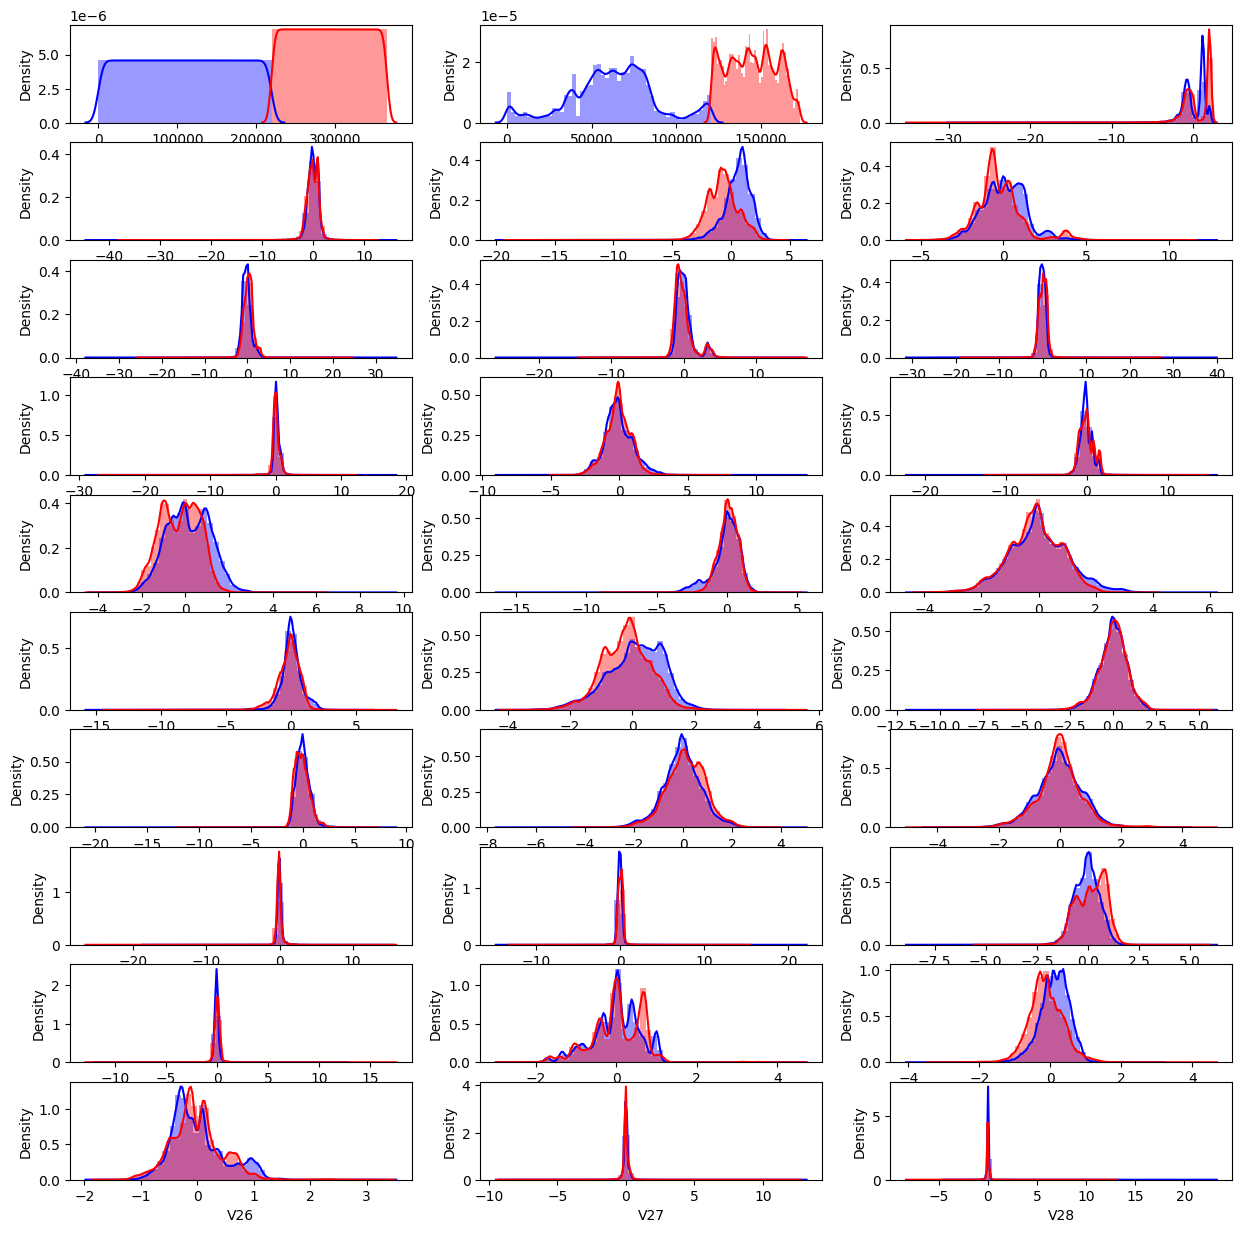

In [7]:
 # Plot a histogram of all the variables in the dataset between train and test
 
fig, ax = plt.subplots(10, 3, figsize=(15, 15))

for variable, subplot in zip(fraud_train.columns, ax.flatten()):
    sns.distplot(fraud_train[variable], ax=subplot, color='blue')
    sns.distplot(fraud_test[variable], ax=subplot, color='red')

<AxesSubplot: >

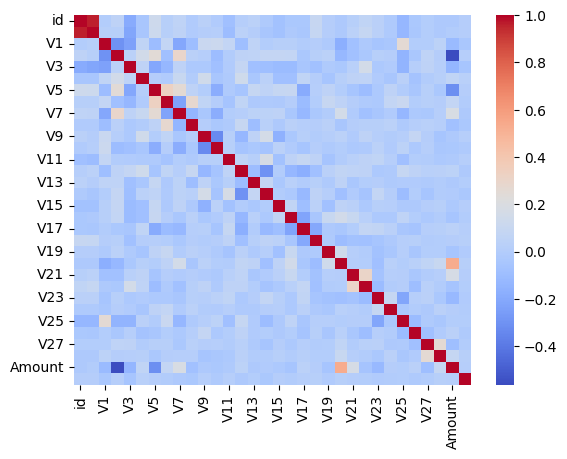

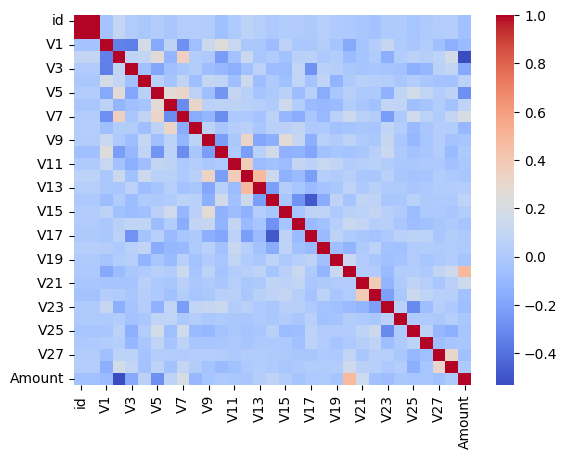

In [8]:
# Plot the correlation between values
plt.figure()
sns.heatmap(fraud_train.corr(), cmap='coolwarm')

plt.figure()
sns.heatmap(fraud_test.corr(), cmap='coolwarm')

### Model Training:

1. GridSearch

2. K-Fold 

3. Ensemble

In [42]:

from sklearn.model_selection import train_test_split, StratifiedKFold, learning_curve, RandomizedSearchCV
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Import gradient boost

from sklearn.ensemble import GradientBoostingClassifier

In [10]:
train_x = fraud_train.drop(['id','Class'], axis=1)
train_y = fraud_train['Class']

In [11]:
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

In [35]:
def model_training(model_fit, train, test, kfolds, params):
    scores = []
    models = []
    for i, (tr_idx, va_idx) in enumerate(kfolds.split(train_x, train_y)):
        tr_x, va_x = train_x.iloc[tr_idx], train_x.iloc[va_idx]
        tr_y, va_y = train_y.iloc[tr_idx], train_y.iloc[va_idx]
        
        model = model_fit(**params)

        model.fit(tr_x.values, tr_y,
                  eval_set=[(va_x.values, va_y)], 
                  verbose=1000)


        preds = model.predict_proba(va_x.values)
        auc = roc_auc_score(va_y, preds[:, 1])

        models.append(model)
        scores.append(auc)
        print(f'Score on fold {i}: {auc}')
        print('-'*50)
    return models, scores
    

GridSearch Models

In [44]:
# XGBoost

xgboost = GradientBoostingClassifier()

# Create a paramter grid

params = {'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000],
          'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5],
          'max_depth': [3, 4, 5, 6, 7, 8]}

xgsearch = RandomizedSearchCV(xgboost, param_distributions=params, n_iter=10, scoring='roc_auc', n_jobs=-1, cv=3, verbose=3)

xgsearch.fit(train_x, train_y)

xgboost_params = xgsearch.best_params_

# Random Forest

forest = RandomForestClassifier()

params = {'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000],
          'criterion': ['gini', 'entropy'],
          'max_depth': [3, 4, 5, 6, 7, 8],
          'max_features': ['auto', 'sqrt', 'log2'],
          }
          
forestsearch = RandomizedSearchCV(forest, param_distributions=params, n_iter=10, scoring='roc_auc', n_jobs=-1, cv=3, verbose=3)

forestsearch.fit(train_x, train_y)

forest_params = forestsearch.best_params_


Fitting 3 folds for each of 10 candidates, totalling 30 fits


In [ ]:
# Train the models and get the scores for each fold

models = [(RandomForestClassifier(), forest_params), (GradientBoostingClassifier(), xgboost_params)]

fold_models = []

for train in models, params:
    model, score = model_training(train, train_x, train_y, kf, params)
    fold_models.append(model)
    print(f'Model: {train.__class__.__name__}, Score: {np.mean(score)}')

In [13]:
test_preds1 = []

for fold in fold_models:
    preds = fold.predict_proba(test_x.values)
    test_preds1.append(preds[:, 1])

# Submission

In [14]:
test_preds1 = np.stack(test_preds1).mean(0)

In [15]:
submission = pd.DataFrame({'id': fraud_test['id'], 'Class': test_preds1})
submission.head()

,id,Class
0,219129,0.001957
1,219130,0.001372
2,219131,0.001087
3,219132,0.003172
4,219133,0.001393


In [16]:
submission.to_csv('submission.csv', index=False)
